<a href="https://colab.research.google.com/github/eladorpBG/ML_assignment3/blob/main/ch11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at https://www.kaggle.com/datasets/avnishnish/mnist-originaland and contains the next data:

- Images: 70,000 examples
- Labels: 70,000 labels



In [1]:
# Upload dataset downloaded from https://www.kaggle.com/datasets/avnishnish/mnist-original an then unzip it
!unzip mnist-original.mat.zip

# Load data
from scipy.io import loadmat
mnist = loadmat("mnist-original.mat")
X = mnist["data"].T
y = mnist["label"][0]
y = y.astype(int)

print(X.shape)
print(y.shape)

Archive:  mnist-original.mat.zip
  inflating: mnist-original.mat      
(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [2]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

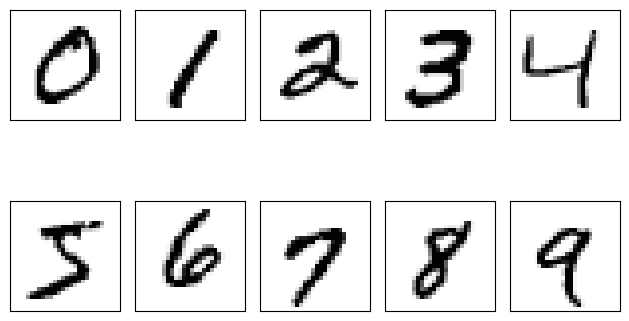

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

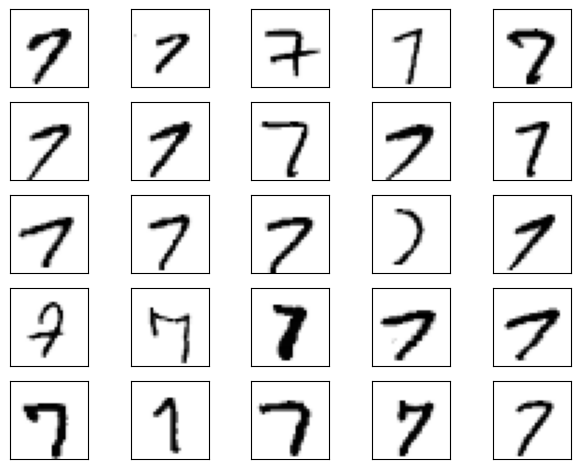

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

test_size = np.round(len(X) * 0.3).astype(int)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=test_size, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [7]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [35]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [22]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the macro AUC

In [38]:
from sklearn.metrics import roc_auc_score
def compute_macro_auc(nnet, X, y, num_labels=10, minibatch_size=200):
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    auc = 0
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        auc += roc_auc_score(onehot_targets, probas, average='macro', multi_class='ovo')

    auc = auc/(i+1)

    return auc

In [39]:
auc = compute_macro_auc(model, X_valid, y_valid)
print(f'Initial valid AUC: {auc:.3f}')

Initial valid AUC: 0.522


In [40]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_train_auc = []
    epoch_valid_auc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_auc = compute_macro_auc(model, X_train, y_train)
        valid_auc = compute_macro_auc(model, X_valid, y_valid)
        train_auc, valid_auc = train_auc*100, valid_auc*100
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train AUC: {train_auc:.2f}% '
              f'| Valid AUC: {valid_auc:.2f}% ')

    return epoch_train_auc, epoch_valid_auc

In [41]:
np.random.seed(123) # for the training set shuffling

epoch_train_auc, epoch_valid_auc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train AUC: 94.35% | Valid AUC: 94.22% 
Epoch: 002/050 | Train AUC: 96.53% | Valid AUC: 96.34% 
Epoch: 003/050 | Train AUC: 97.50% | Valid AUC: 97.31% 
Epoch: 004/050 | Train AUC: 97.95% | Valid AUC: 97.79% 
Epoch: 005/050 | Train AUC: 98.23% | Valid AUC: 98.11% 
Epoch: 006/050 | Train AUC: 98.40% | Valid AUC: 98.26% 
Epoch: 007/050 | Train AUC: 98.52% | Valid AUC: 98.41% 
Epoch: 008/050 | Train AUC: 98.57% | Valid AUC: 98.40% 
Epoch: 009/050 | Train AUC: 98.65% | Valid AUC: 98.54% 
Epoch: 010/050 | Train AUC: 98.70% | Valid AUC: 98.57% 
Epoch: 011/050 | Train AUC: 98.75% | Valid AUC: 98.63% 
Epoch: 012/050 | Train AUC: 98.78% | Valid AUC: 98.61% 
Epoch: 013/050 | Train AUC: 98.82% | Valid AUC: 98.72% 
Epoch: 014/050 | Train AUC: 98.86% | Valid AUC: 98.77% 
Epoch: 015/050 | Train AUC: 98.87% | Valid AUC: 98.73% 
Epoch: 016/050 | Train AUC: 98.92% | Valid AUC: 98.80% 
Epoch: 017/050 | Train AUC: 98.95% | Valid AUC: 98.79% 
Epoch: 018/050 | Train AUC: 98.96% | Valid AUC: 

## Evaluating the neural network performance

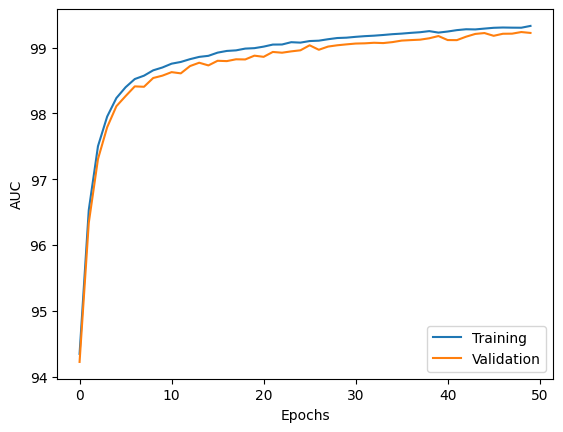

In [42]:
plt.plot(range(len(epoch_train_auc)), epoch_train_auc,
         label='Training')
plt.plot(range(len(epoch_valid_auc)), epoch_valid_auc,
         label='Validation')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [43]:
test_auc = compute_macro_auc(model, X_test, y_test)
print(f'Test AUC: {test_auc*100:.2f}%')

Test AUC: 99.23%


Plot failure cases:

In [44]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

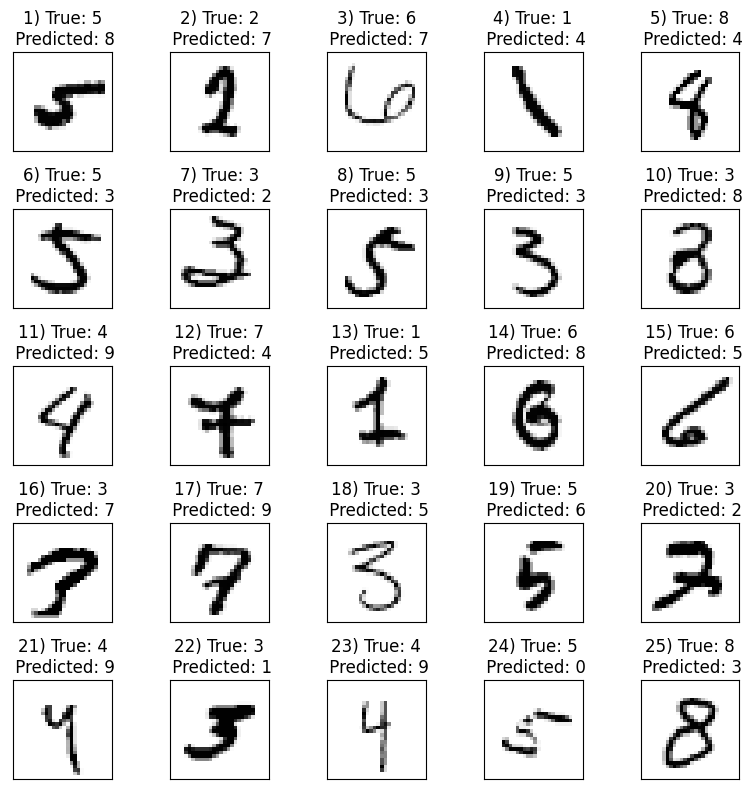

In [45]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()